# Spatial multi-omics analysis


Spatial multi-omics, can give you insights on how different molecules might interact together in space. We will therefore have a look at the Vicari et al., 2024 dataset, which applies mass spectrometry and VISIUM on the same slice. The experiments were conducted on mouse brain which were unilaterally treated with 6'OHDT, causing dopaminergic neuron depletion on the treated site. For more information check out the [paper by Vicari et al., 2024](https://www.nature.com/articles/s41587-023-01937-y).

In this session, you will learn, how spatial multi-omics measurement can look like from the data perspective, how to store them conveniently, look at potential problems of spatial multi-omics measurements and how to do downstream analysis on this type of data in separate and joint manner. 


**References**:
* [Data: Vicari et al., 2024](https://www.nature.com/articles/s41587-023-01937-y).
* [MAGPIE Williams et al., 2025](https://www.biorxiv.org/content/10.1101/2025.02.26.640381v1)
* https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/sdata_from_scratch.html
* https://biofam.github.io/MOFA2/
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF

In [3]:
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdata as sd
import matplotlib.pyplot as plt


from sklearn.decomposition import NMF
from scipy.stats import pearsonr
from mofapy2.run.entry_point import entry_point #TODO: add in requirements mofapy2-0.7.2

warnings.filterwarnings("ignore")

/Users/wangjunhu/miniconda/envs/spatialdata/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/wangjunhu/miniconda/envs/spatialdata/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Load the Vicari et al., 2024 spatial multi-omics data.

We will use sample: ```V11L12-109_B1``` in this tutorial. It is a mouse brain from the substantia nigra region, which was unilaterly treated with 6'OHDT causing dopaminergic neuron depletion at the site of action. Mass spectrometry and visium were conducted consecutively on the same slide, respectively, creating two coordinate systems that need to be aligned. The data provided in this tutorial was already aligned using [MAGPIE](https://www.biorxiv.org/content/10.1101/2025.02.26.640381v1), which is a landmark based alignment tool. The generated data contained only one H&E image, in MAGPIE you can align based on the principal components of the modality with missing H&E. Additionally, MAGPIE provides aggregation/ 1:1 matching of observations, by matching mass spectrometry observations to Visium spots. For more information, check out the [MAGPIE paper](https://www.biorxiv.org/content/10.1101/2025.02.26.640381v1).

Inside the ```V11L12-109_B1``` folder, you will find three datasets: the Visium data (```visium```), the raw mass spectrometry data without aggregation (```msi```), and the 1:1 matched mass spectrometry data (```msi_aggregated```). The MAGPIE workflow formats the mass spectrometry data so that it can be accessed using the standard Visium read functions.

In [4]:
visium = sc.read_visium("data/V11L12-109_B1/visium/", library_id="rna")
msi = sc.read_visium("data/V11L12-109_B1/msi_aggregated/", library_id="msi")
print(msi, visium)

AnnData object with n_obs × n_vars = 2394 × 1538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial' AnnData object with n_obs × n_vars = 3120 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


**Task 1**: Quick recap, create a SpatialData from scratch using our spatial multi-omics data. Use the parsers for the H&E and AnnData Tables (Hint: check out the [sdata from scratch tutorial](https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/sdata_from_scratch.html))

In [5]:
from PIL import Image
from spatialdata.models import Image2DModel, TableModel

image = np.array(Image.open("data/V11L12-109_B1/transformed.png"))
im = image.transpose(2, 1, 0) # should be (channel, y, x)
img_for_sdata = Image2DModel.parse(data=im, scale_factors=(2, 2, 2))  # this creates 4 downscaled images as well

visium_ = TableModel.parse(visium)
msi_ = TableModel.parse(msi)

sdata = sd.SpatialData(
    images={"hne": img_for_sdata},
    tables={"rna": visium_, "msi": msi_},
)
sdata

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


SpatialData object
├── Images
│     └── 'hne': DataTree[cyx] (4, 1979, 2000), (4, 989, 1000), (4, 494, 500), (4, 247, 250)
└── Tables
      ├── 'msi': AnnData (2394, 1538)
      └── 'rna': AnnData (3120, 32285)
with coordinate systems:
    ▸ 'global', with elements:
        hne (Images)

You may have noticed that the Visium dataset contains many more observations than the MSI dataset. However, after performing a 1:1 matching, both should contain the same set of observations. To achieve this, we need to manually take the intersection of the two datasets. We can also library normalize, log-scale the data and derive highly variable features.

In [6]:
msi_barcodes = set(msi.obs_names)
visium_barcodes = set(visium.obs_names)

intersection = set.intersection(msi_barcodes, visium_barcodes)

visium = visium[list(intersection)]
msi = msi[list(intersection)]

# save raw data
visium.layers["counts"] = visium.X.copy()
sc.pp.normalize_total(visium, target_sum=10000.)
sc.pp.log1p(visium)

msi.layers["raw"] = msi.X.copy()
sc.pp.normalize_total(msi, target_sum=1.)
sc.pp.log1p(msi)

In [7]:
# feature selection
# highly variable features
sc.pp.highly_variable_genes(visium, n_top_genes= 3000, subset=True)

print(visium, msi)

AnnData object with n_obs × n_vars = 2344 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'counts' AnnData object with n_obs × n_vars = 2344 × 1538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'raw'


In scanpy, the function sc.pl.spatial is very convenient. You simply provide a feature name—stored in .obs—and it will plot that feature overlaid on the H&E image. From the supplementary information, we know that ```mz-390.16864``` can be assigned to Dopamine. We can plot the Dopamine signal and look at the distribution in space. **Quick question**: how would you do it with SpatialData?

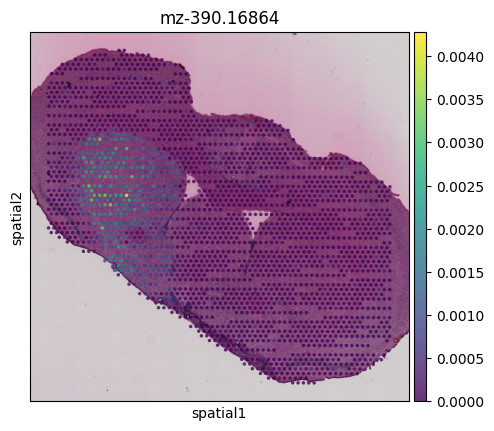

In [8]:
sc.pl.spatial(msi, img_key="hires", color="mz-390.16864",alpha=0.8)

As expected, we can see an unilateral distribution of Dopamine. 

**Task 2**: Plot the Penk gene for the Visium data using the ```sc.pl.spatial``` function. What is the function of Penk and how is connected to Dopamine?

## Learning spatial patterns

One of the key tasks in spatial omics analysis is identifying observations with similar expression profiles. In spatial data, this translates into detecting spatial domains or patterns, where groups of observations share similar expression patterns. In this section, we will use two approaches to identify such observations (in our case, spots), e.g. non-negative matrix factorization (NMF) and [MOFA](https://www.embopress.org/doi/full/10.15252/msb.20178124), respectively.

We will first apply non-negative matrix factorization (NMF) separately on both modalities. Since we already know the distribution of Dopamine (mz-390.16864), we can initially apply NMF to the Visium dataset and compute the cross-correlation between each NMF factor and the Dopamine distribution.

We will:
1. Visualize the learned latent embeddings (spatial patterns).
2. Compute cross-correlations, focusing on NMF factors that show strong correlation with Dopamine.
3. Visualize the dopamine distribution alongside the most correlated NMF factors and their top loadings.
4. Compare the patterns across both modalities to check whether similar spatial patterns are learned.


After that we will use MOFA to learn spatial patterns jointly.


In [9]:
n_factors = 15 # you can play around with number of latent factors
seed = 2025
nmf = NMF(n_components = n_factors, random_state= seed, init = "nndsvd")

In [10]:
Z_rna = nmf.fit_transform(visium.X)
loadings_rna = nmf.components_

for factor in range(n_factors):
    visium.obs[f"NMF_Z_{factor + 1}"] = Z_rna[:, factor]

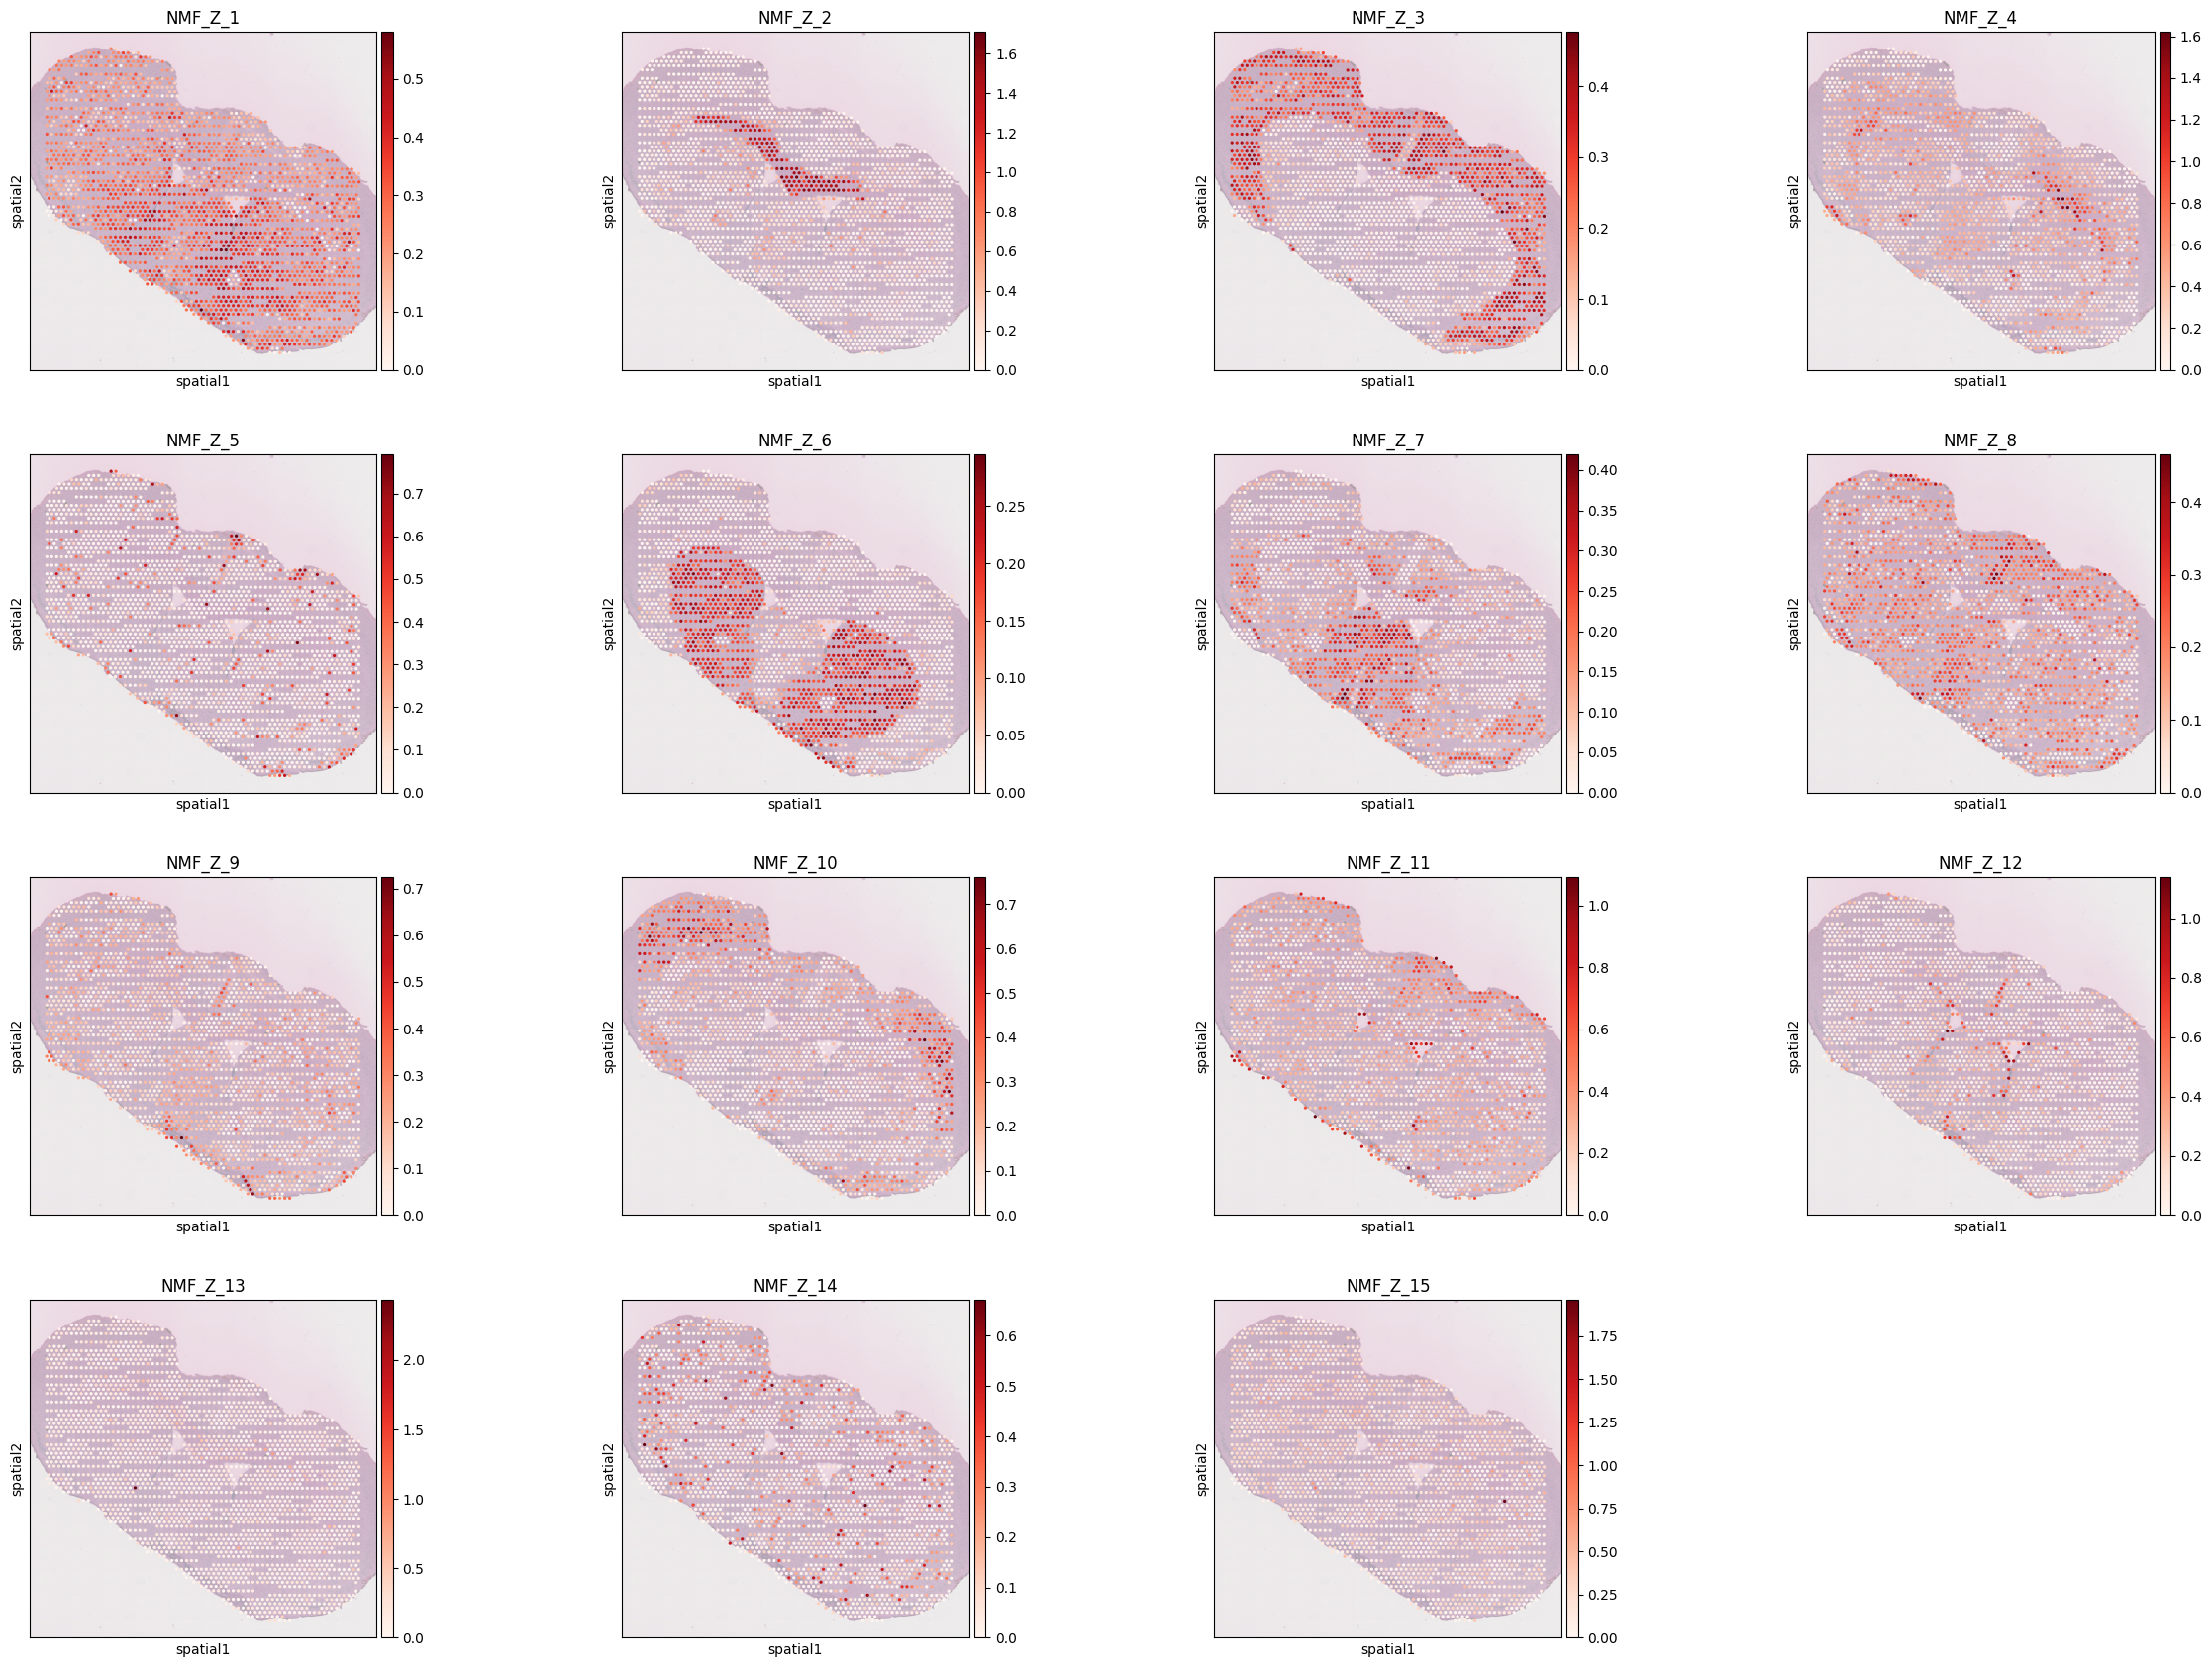

In [11]:
sc.pl.spatial(visium, color=[f"NMF_Z_{factor+1}" for factor in range(n_factors)], color_map="Reds", alpha_img = 0.4)

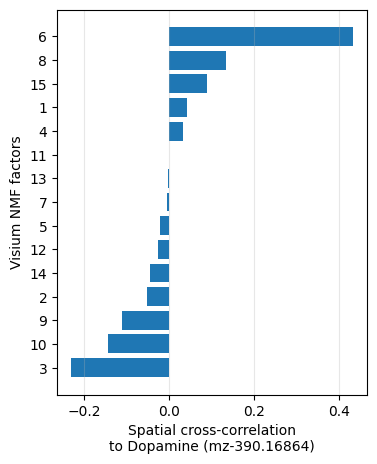

In [12]:
# compute cross correlation

dopamine = msi[:, "mz-390.16864"].X.toarray()

correlations = []
for factor in range(n_factors):
    correlations.append(pearsonr(dopamine.flatten(), Z_rna[:, factor])[0])

correlations = np.array(correlations)

factors = np.arange(len(correlations))
factor_labels = [str(i + 1) for i in factors]

sorted_indices = np.argsort(correlations)[::-1]
sorted_correlations = correlations[sorted_indices]
sorted_labels = [factor_labels[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(4, 5))

bars = ax.barh(range(len(sorted_correlations)), sorted_correlations)

ax.set_yticks(range(len(sorted_correlations)))
ax.set_yticklabels(sorted_labels)
ax.set_xlabel("Spatial cross-correlation\nto Dopamine (mz-390.16864)")
ax.set_ylabel("Visium NMF factors")
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.show()

In [13]:
Z_msi = nmf.fit_transform(msi.X)
loadings_msi = nmf.components_

for factor in range(n_factors):
    msi.obs[f"NMF_Z_{factor + 1}"] = Z_msi[:, factor]

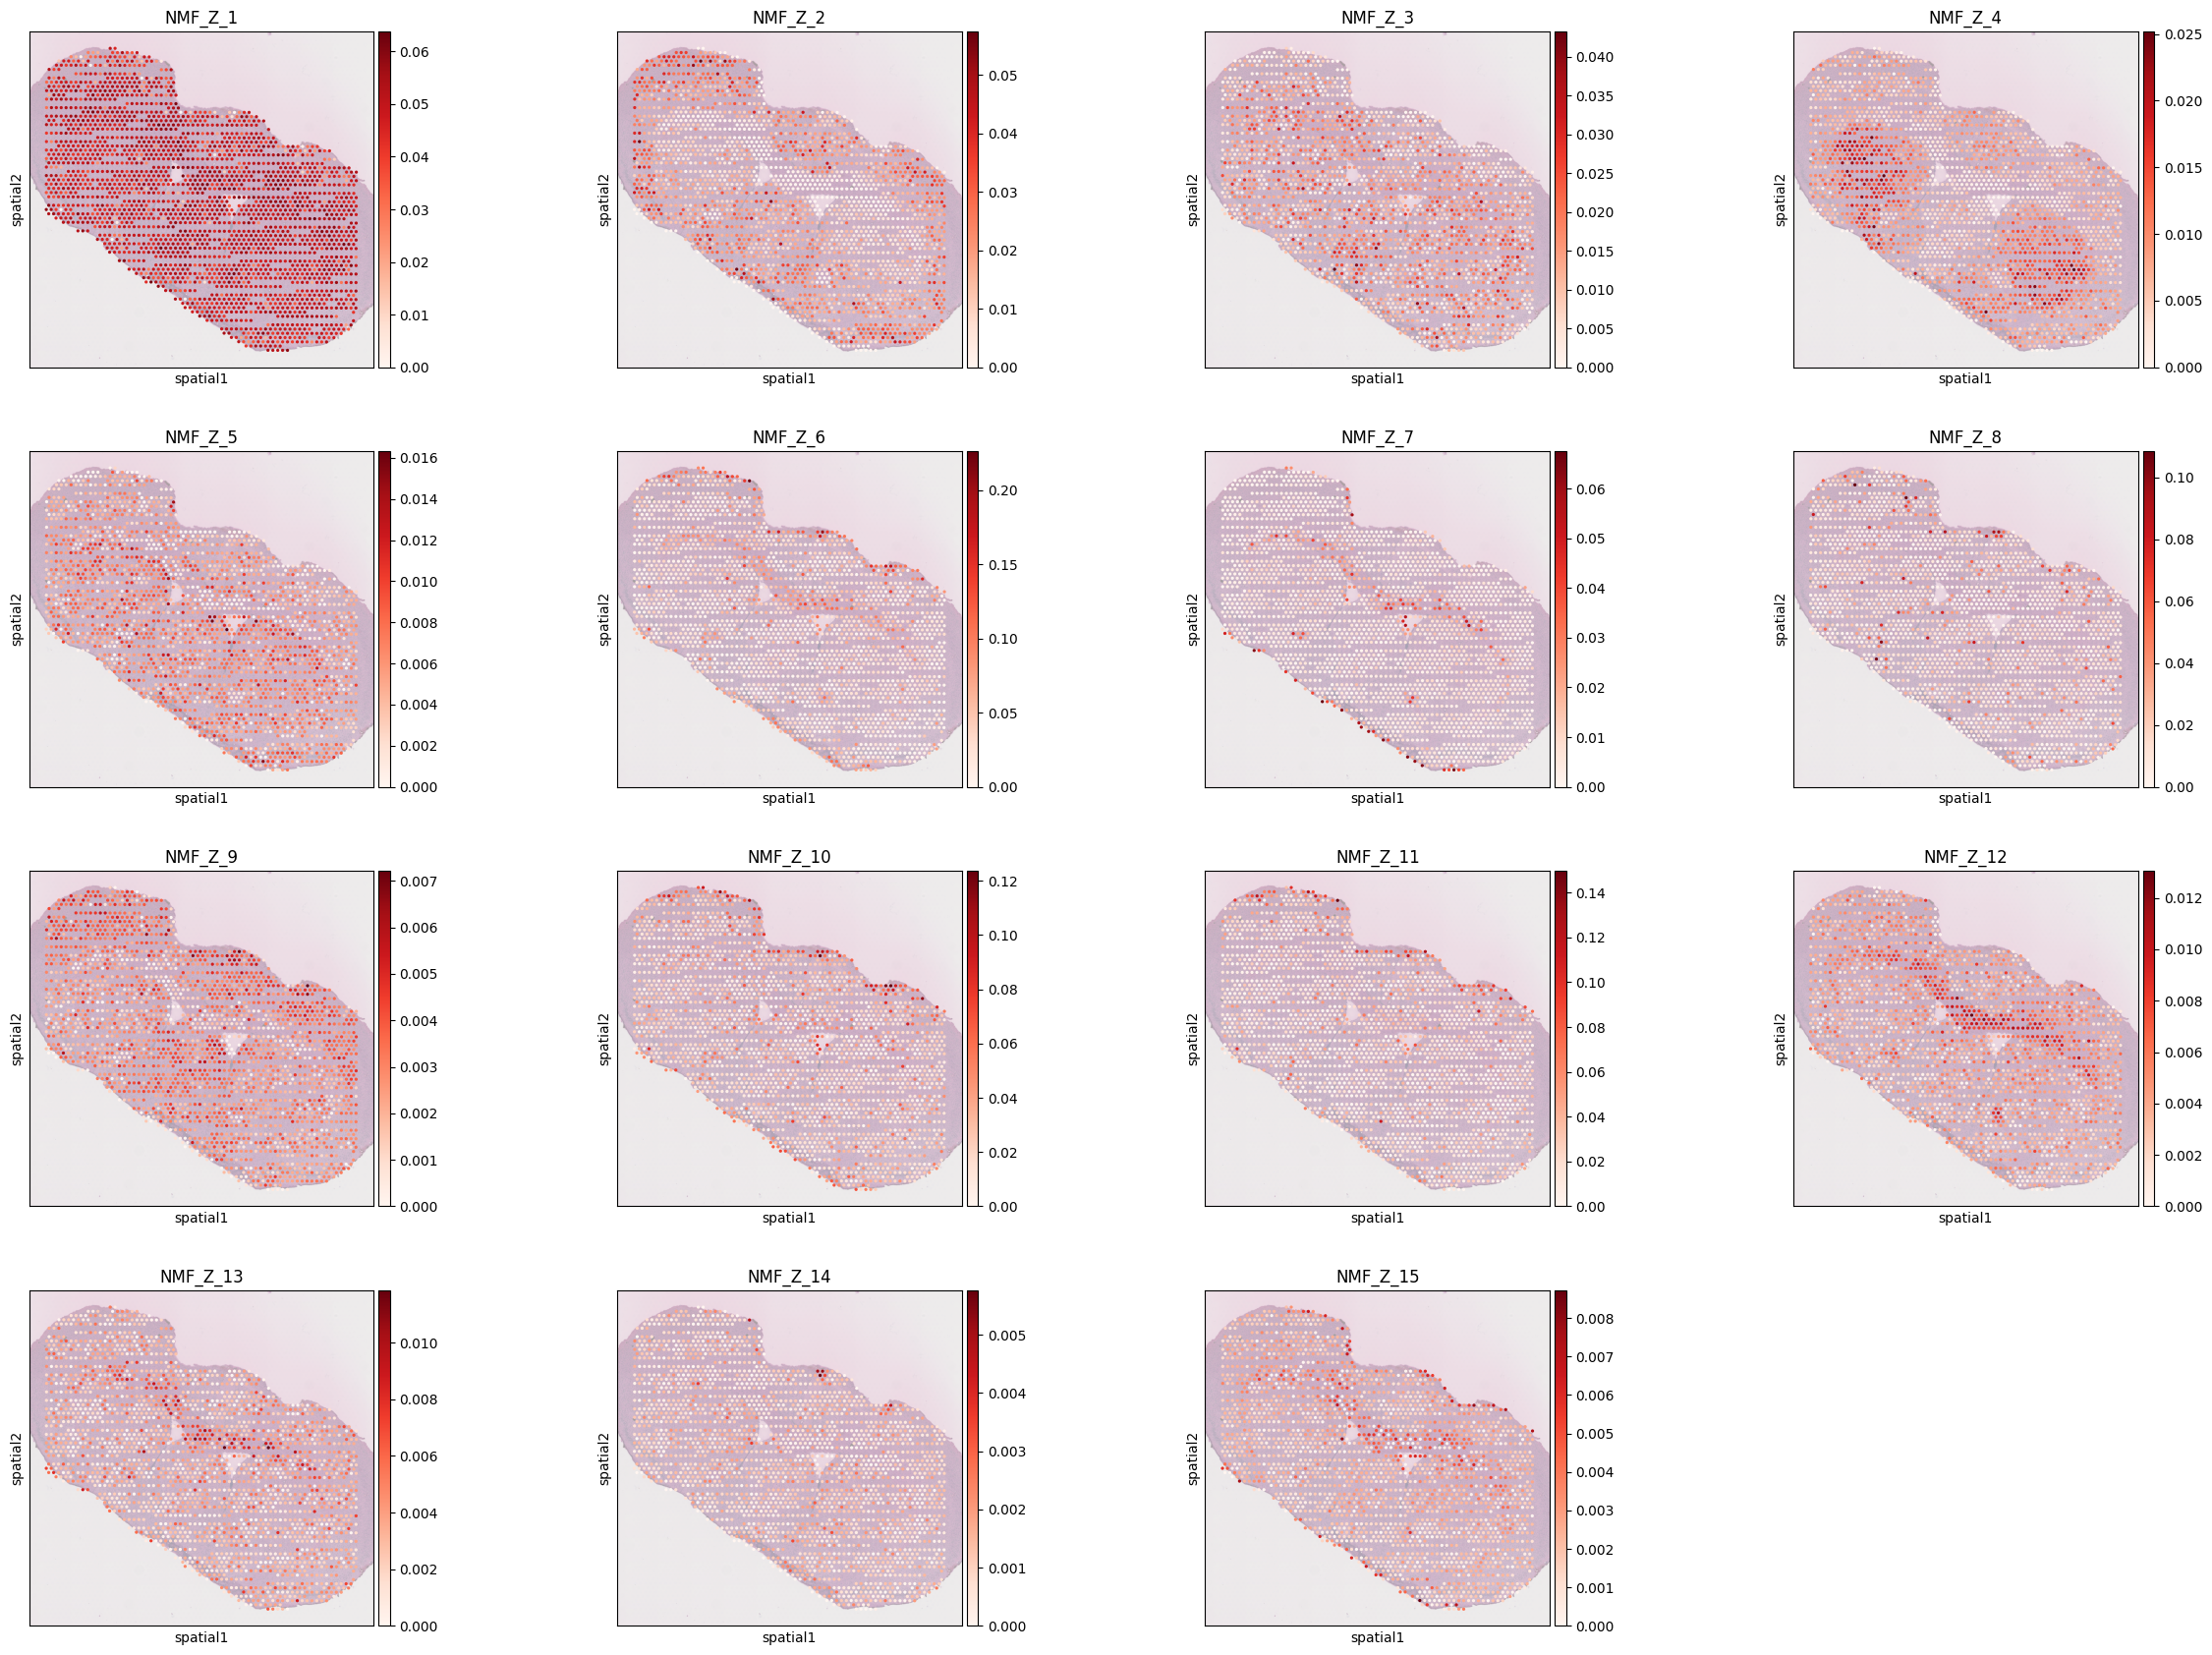

In [14]:
sc.pl.spatial(msi, color=[f"NMF_Z_{factor+1}" for factor in range(n_factors)], color_map="Reds", alpha_img =0.4)

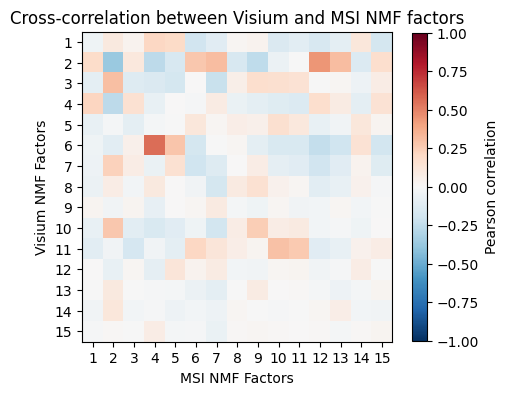

In [13]:
correlations = []
for factor_rna in range(n_factors):
    row_correlations = []
    for factor_msi in range(n_factors):
        corr = pearsonr(Z_rna[:, factor_rna].flatten(), Z_msi[:, factor_msi].flatten())[0]
        row_correlations.append(corr)
    correlations.append(row_correlations)

correlation_matrix = np.array(correlations)

fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(correlation_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(n_factors))
ax.set_yticks(range(n_factors))
ax.set_xticklabels([f"{i+1}" for i in range(n_factors)])
ax.set_yticklabels([f"{i+1}" for i in range(n_factors)])

plt.xlabel("MSI NMF Factors")
plt.ylabel("Visium NMF Factors")
plt.title("Cross-correlation between Visium and MSI NMF factors")

cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label("Pearson correlation")
plt.show()

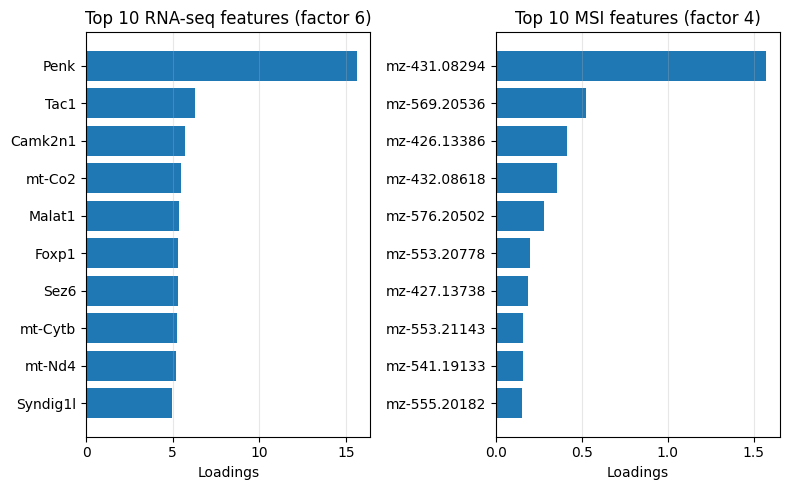

In [16]:
df_rna = pd.DataFrame({
    "feature": visium.var_names,
    "loading": loadings_rna[6-1, :]  # Factor 3
})

df_msi = pd.DataFrame({
    "feature": msi.var_names,
    "loading": loadings_msi[4-1, :]  # Factor 4
})


df_rna_sorted = df_rna.reindex(df_rna["loading"].abs().argsort()[::-1])
df_msi_sorted = df_msi.reindex(df_msi["loading"].abs().argsort()[::-1])

top_rna = df_rna_sorted.head(10)
top_msi = df_msi_sorted.head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

y_pos_rna = np.arange(len(top_rna))
bars1 = ax1.barh(y_pos_rna, top_rna["loading"]),# color='')
ax1.set_yticks(y_pos_rna)
ax1.set_yticklabels(top_rna["feature"])
ax1.set_xlabel("Loadings")
ax1.set_title("Top 10 RNA-seq features (factor 6)")
ax1.invert_yaxis()
ax1.grid(axis="x", alpha=0.3)

y_pos_msi = np.arange(len(top_msi))
bars2 = ax2.barh(y_pos_msi, top_msi["loading"])#, color='orange')
ax2.set_yticks(y_pos_msi)
ax2.set_yticklabels(top_msi["feature"])
ax2.set_xlabel("Loadings")
ax2.set_title("Top 10 MSI features (factor 4)")
ax2.invert_yaxis()
ax2.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

**Task 1**: Look up genes and/ or m/z ratios (use the supps provided in the data folder) of your choice. You can play around with plotting different factors and look at their top loadings for both Visium and mass spectrometry.

## Learning spatial patterns jointly using MOFA

In this exercise, we will use the 1:1 matched data, i.e., ```visium``` and ```msi_aggregated``` datasets, and train a MOFA model. MOFA applies a univariate prior (e.g., a Normal prior) on the learned factors. (Optional: later, you can compare this with MEFISTO, which uses a multivariate prior on the factors.)

Compared to our previous NMF analysis, MOFA produces real-valued factors and loadings. Furthermore, it learns latent factors from a multi-modality (multi-view) perspective, capturing shared and modality-specific variation across datasets.

For MOFA, the data must be normalized by library size, and the features should be scaled to have a mean of 0 and a standard deviation of 1.

In [15]:
# preprocess: library size normalization and then per feature scaling (mean=0, sd=1)
visium_mofa = visium.copy()
visium_mofa.X = visium_mofa.layers["counts"].copy()
sc.pp.normalize_total(visium_mofa, target_sum=10000.)
sc.pp.log1p(visium_mofa)
sc.pp.scale(visium_mofa)


msi_mofa = msi.copy()
msi_mofa.X = msi_mofa.layers["raw"].copy()
sc.pp.normalize_total(msi_mofa, target_sum=1.) # total ion count norm
sc.pp.log1p(msi_mofa)
sc.pp.scale(msi_mofa)

In [16]:
mofaplus = entry_point()

# data structure [[modality1], [modality2]] within modality1 [group1, group2, ...]

mofaplus.set_data_matrix([[visium_mofa.X], [msi_mofa.X]])

mofaplus.set_model_options(
            factors=n_factors,
            spikeslab_factors=False,
            spikeslab_weights=True,
            ard_factors=False,
            ard_weights=True,
            )
        
mofaplus.set_train_options(
            iter = 1000, 
            convergence_mode = "fast", 
            gpu_mode = False,
            gpu_device=None,
            seed=seed,
)

mofaplus.build()
mofaplus.run()

MOFA_loadings = mofaplus.model.nodes["W"].getExpectation()
MOFA_Z = mofaplus.model.nodes["Z"].getExpectation()

# save in AnnData
for factor in range(n_factors):
    visium.obs[f"MOFA_Z_{factor + 1}"] = MOFA_Z[:, factor]
    msi.obs[f"MOFA_Z_{factor + 1}"] = MOFA_Z[:, factor]


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group

**Task 1**: Plot the learned MOFA factors with ```sc.pl.spatial()``` function as previously. Which factors seems to be associated with dopaminergic neurons?

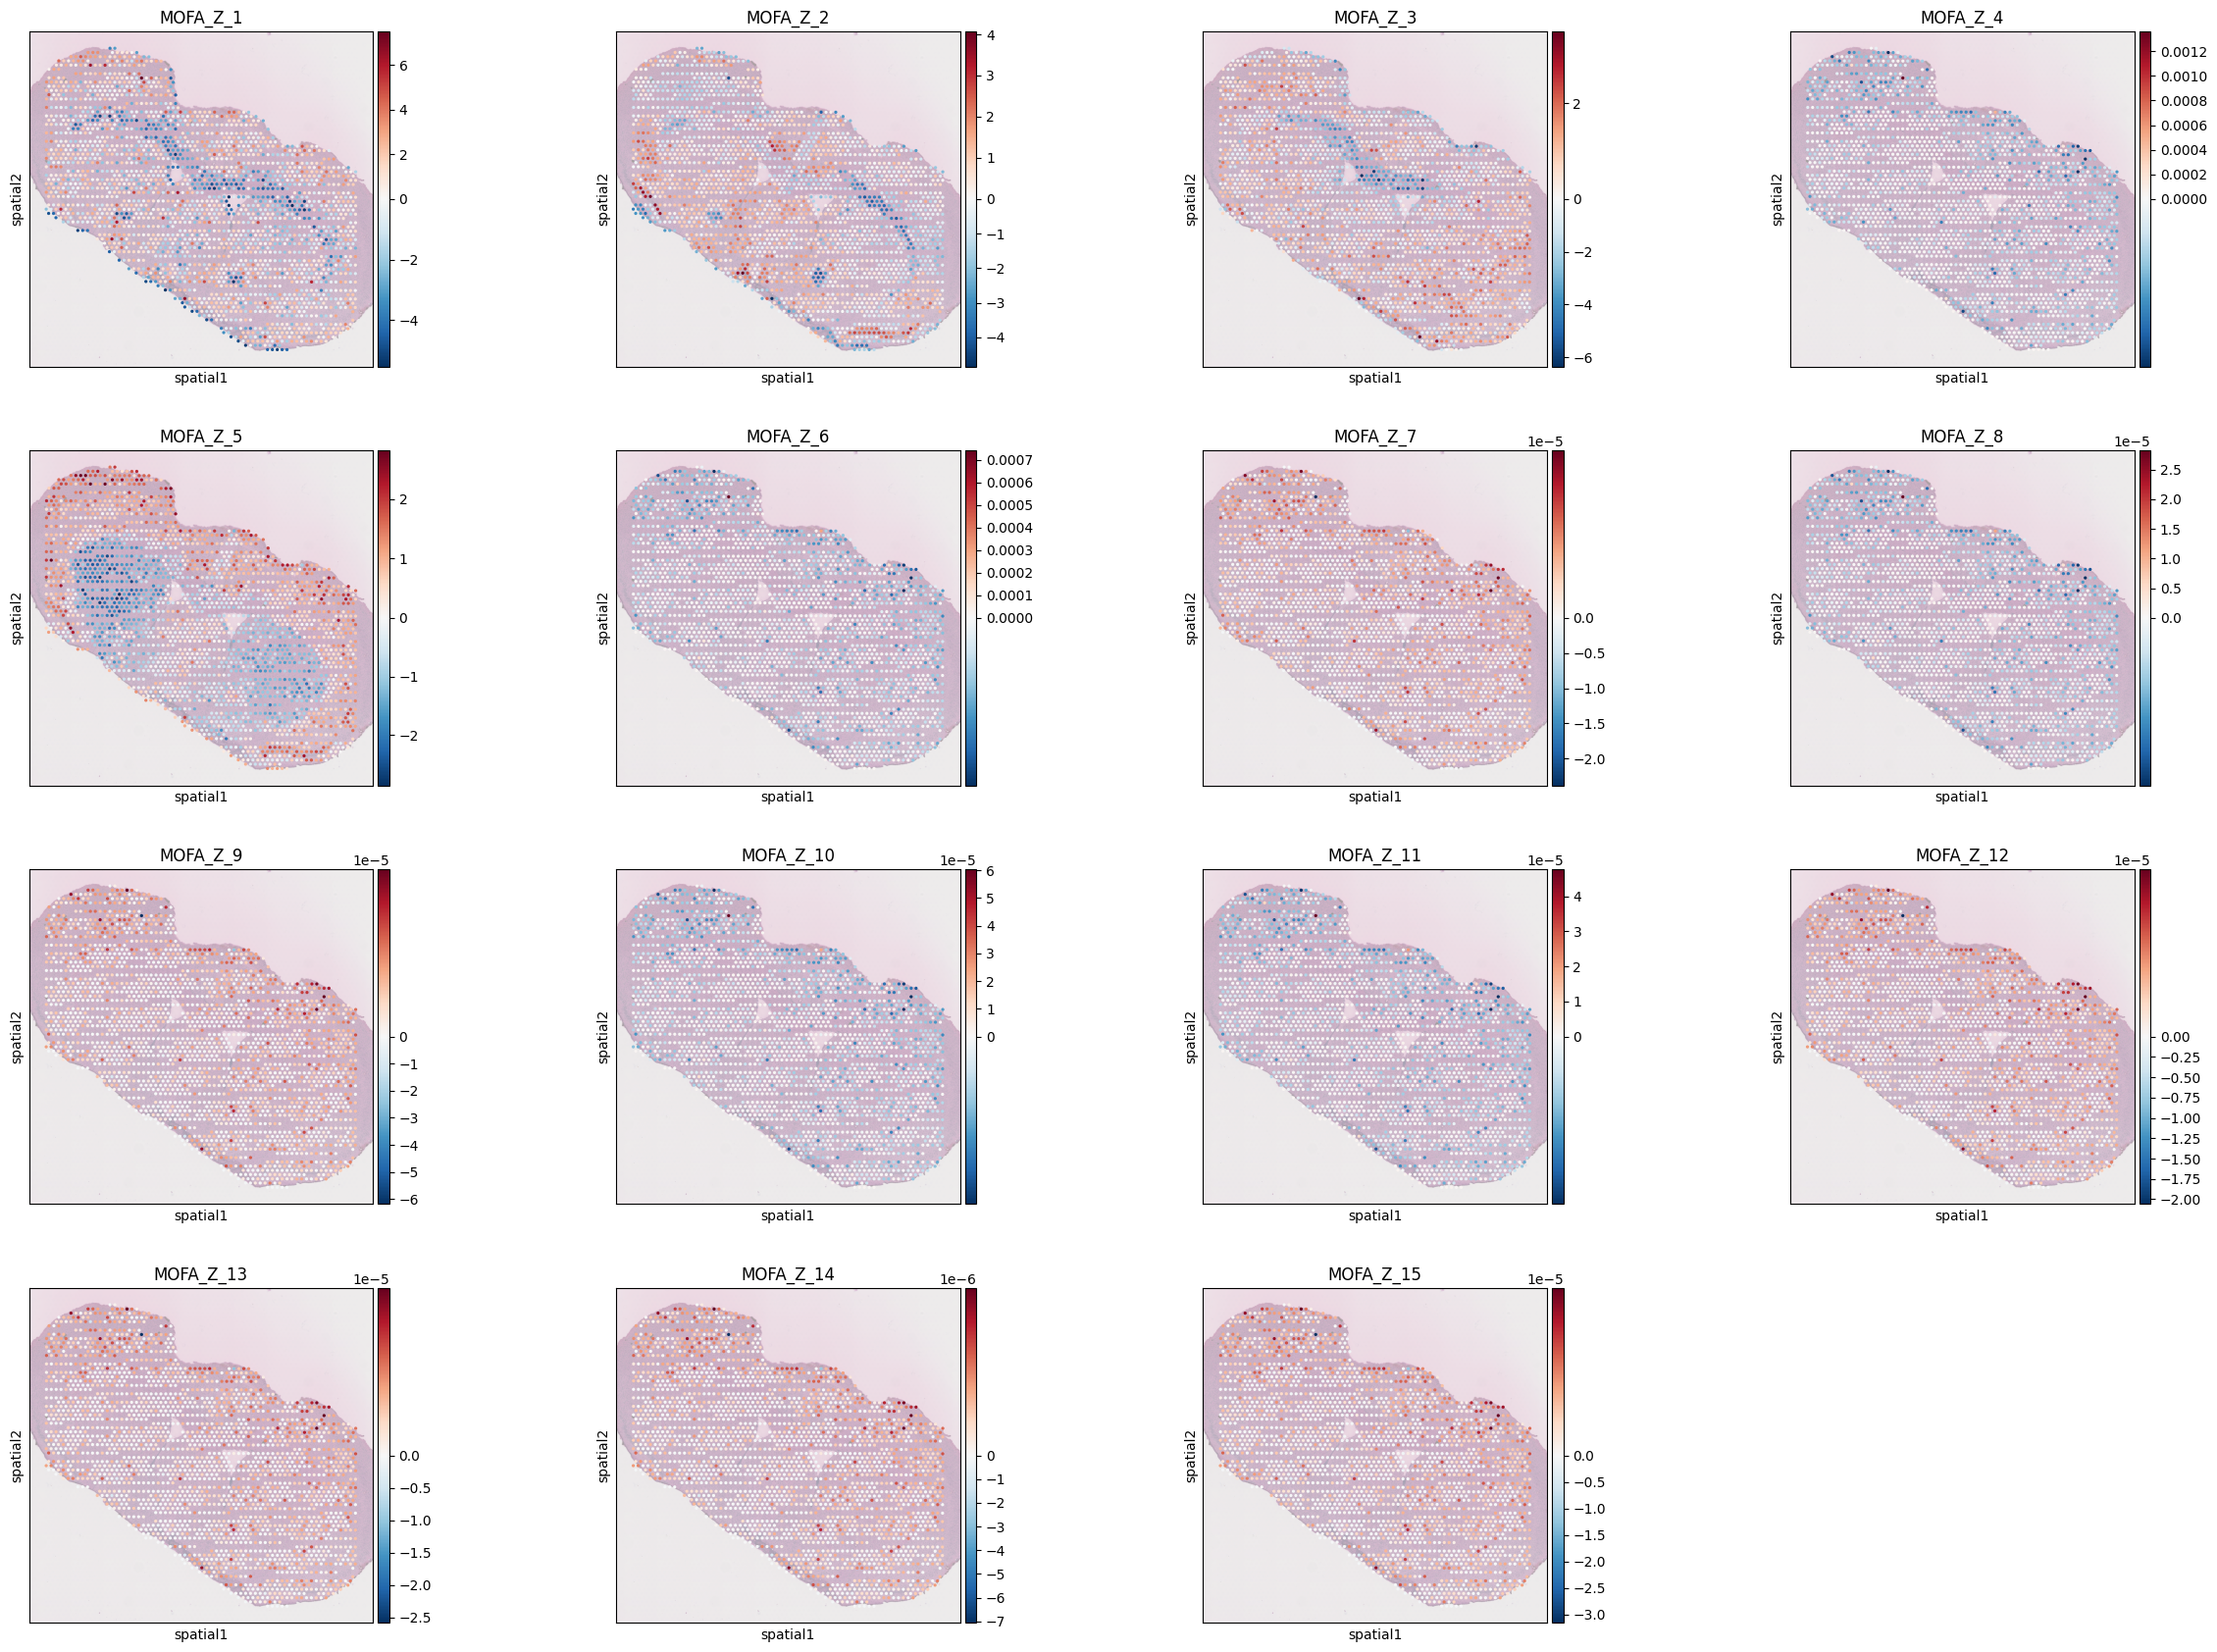

In [17]:
sc.pl.spatial(visium, color=[f"MOFA_Z_{factor+1}" for factor in range(n_factors)], color_map="RdBu_r", vcenter=0, alpha_img=0.4)

**Task 2**: Factor 5 seems to be representing the dopamin associated region. Plot the loadings for each of the modalities and look at their top loadings (Hint: use the code from previous section and adapt it). What do you observe? Have a closer look at features of your interest.

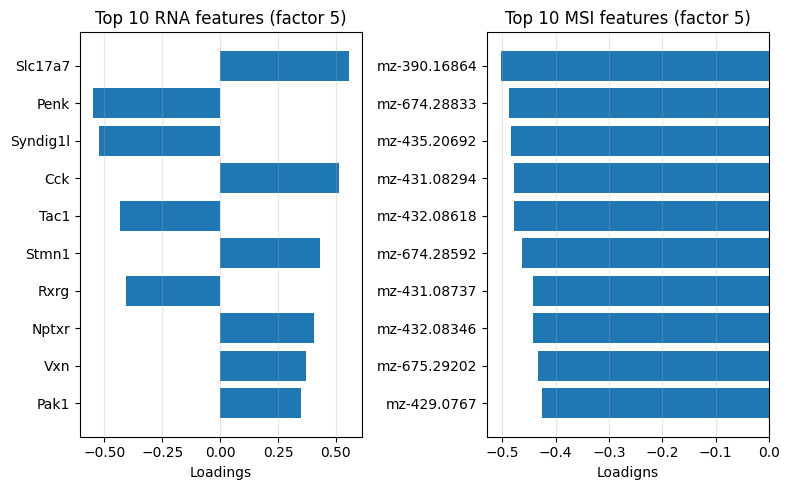

In [18]:
df_rna = pd.DataFrame({
    "feature": visium.var_names,
    "loading": MOFA_loadings[0][:, 5-1]
})

df_msi = pd.DataFrame({
    "feature": msi.var_names,
    "loading": MOFA_loadings[1][:, 5-1]
})


df_rna_sorted = df_rna.reindex(df_rna["loading"].abs().argsort()[::-1])
df_msi_sorted = df_msi.reindex(df_msi["loading"].abs().argsort()[::-1])

top_rna = df_rna_sorted.head(10)
top_msi = df_msi_sorted.head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

y_pos_rna = np.arange(len(top_rna))
bars1 = ax1.barh(y_pos_rna, top_rna["loading"]),# color='')
ax1.set_yticks(y_pos_rna)
ax1.set_yticklabels(top_rna["feature"])
ax1.set_xlabel("Loadings")
ax1.set_title("Top 10 RNA features (factor 5)")
ax1.invert_yaxis()
ax1.grid(axis="x", alpha=0.3)

y_pos_msi = np.arange(len(top_msi))
bars2 = ax2.barh(y_pos_msi, top_msi["loading"])#, color='orange')
ax2.set_yticks(y_pos_msi)
ax2.set_yticklabels(top_msi["feature"])
ax2.set_xlabel("Loadigns")
ax2.set_title("Top 10 MSI features (factor 5)")
ax2.invert_yaxis()
ax2.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

**Task 3**: Writing custom functions to plot results of your factor analysis is time consuming and inefficient. Hence, MOFA comes a long with a convenient plotting package named [mofax](https://github.com/bioFAM/mofax). Have a look of different plots and their implications. (Optional: install mofax and use the functions to explore the outcomes of your mofa model).

In [ ]:
%pip install mofax

import mofax as mfx

**Task 4**: Previously we had only positive loadings but in MOFA you can also have negative loadings. How can you interpret them? How can you determine, the importance of each factor for each modality?

**Task 5**: Do you see a difference between non-negative vs. real-valued analysis, and separate vs. joint analysis of spatial multi-omics data?

**Task 6**: What kinds of downstream analyses, other than examining the loadings, could you imagine?

## Optional 1: Do clustering on your data. Can you identify groups of observations that are similar to the learned spatial patterns? (Hint: check out a basic [scanpy tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#normalization))

## Optional 2: Go through the [SpatialData alignement tutorial](https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/alignment_using_landmarks.html). Create an affine transformation to transform the coordinate system of one modality and try to recover it. Keep in mind that in this alignment tutorial, they assume two H&E images to find landmarks. Can you think of something else to use for defining these landmarks in the modality without H&E? (Hint: check what MAGPIE is doing).

## Optional 3: Use [MEFISTO](https://www.nature.com/articles/s41592-021-01343-9) to learn spatial patterns. MEFISTO uses a multivariate prior (Gaussian process) to model observation-observation dependencies. Compare with the MOFA and NMF results. (Warning: switch to MEFISTO kernel to use MEFISTO without problems, the [numpy==2.0.0](https://numpy.org/devdocs/release/2.0.0-notes.html) changed the alias from np.Inf to np.inf and thus leads to abortion of the training). Save your data, and create a new notebook.


With the existing code you have to just add covariates, e.g. in our case the x,y-coordinates before training the mofaplus module. We will use sparse Gaussian processes, i.e. use a set of inducing points to approximate the covariance matrix.
```
mofaplus.set_covariates(
    sample_cov=[covariates], # this is per group 
    covariates_names=["imagerow", "imagecol"]
    )
n_inducing = 256
n_obs = visium_mofa.n_obs
      
mofaplus.set_smooth_options(
                sparseGP=True,
                warping=False,
                start_opt=10, 
                opt_freq=10,
                frac_inducing=n_inducing/n_obs,
                )
```

## Optional 4: Use the binned Xenium data from the SpatialData introduction to conduct some downstream analysis of your choice.